<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Bias-Variance Tradeoff
</h1><br>
In this exercise, we'll implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. Therefore, we have only one feature. This will help us use **model selection** techniques (*hyperparameter tuning*) to show different bias-variance properties and how we can select hyperparameter values that yields the lowest *Cross Validation Error* which is an estimate of how well the model will generalize when tested on unseen data.

Let's first import all the libraries needed and explore the data.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat, whosmat
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures, scale
from sklearn.linear_model import LinearRegression
from warnings import filterwarnings
from scipy.linalg import pinv
from matplotlib.image import imread
from IPython.display import HTML, display

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
filterwarnings('ignore')

In [2]:
whosmat('../data/ex5data1.mat')

[('X', (12, 1), 'double'),
 ('y', (12, 1), 'double'),
 ('Xtest', (21, 1), 'double'),
 ('ytest', (21, 1), 'double'),
 ('Xval', (21, 1), 'double'),
 ('yval', (21, 1), 'double')]

As we can see from the above, the matlab file has 6 objects:
* $X$: training feature matrix
* $y$: training target variable
* $Xtest$: test feature matrix
* $ytest$: test target variable
* $Xval$: validation feature matrix
* $yval$: validation target variable
* $m_{train}$: 12 training examples
* $m_{test}$: 21 test examples
* $m_{val}$: 21 test examples

The training set will be used to fit the model and get the $\theta$. The validation set will be used for hyperparameter tuning such as determining the regularization parameter $\lambda$. Finally, the test set will be used for evaluating the performance of the model on unseeen examples and report that as the **generalization error**.

The hypothesis function is:
$$h_\theta(x^i) = \theta^{T}x^i$$
The cost functions will be:
$$J(\theta) = \frac {1} {2m} \sum_{i = 1}^{m}\Big(h_\theta(x^i) - y^i\Big)^2 + \frac {\lambda} {2m}\sum_{j = 1}^n \theta_j^2 \quad; \ used \ to\ min\ \theta$$

$$J_{cv}(\theta) = \frac {1} {2m_{cv}} \sum_{i = 1}^{m_{cv}}\Big(h_\theta(x_{cv}^i) - y_{cv}^i\Big)^2 \quad; \ used \ for\ hyperparameter\ tuning$$

$$J_{test}(\theta) = \frac {1} {2m_{test}} \sum_{i = 1}^{m_{test}}\Big(h_\theta(x_{test}^i) - y_{test}^i\Big)^2 \quad; \ used\ to\ estimate\ the\ generlization\ error$$
Below is a scatter plot of the training data:

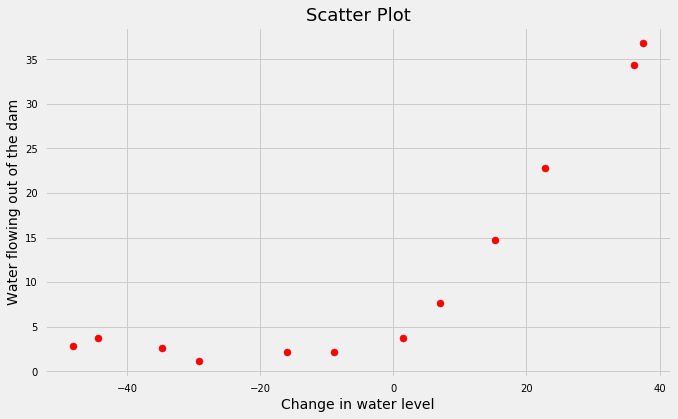

In [3]:
# load the data
data = loadmat('../data/ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']
mtrain = len(y)
mval = len(yval)
mtest = len(ytest
           )
# scatter plot
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(X, y, c = 'r', marker = 'o')
plt.xlabel('Change in water level', fontsize = 14)
plt.ylabel('Water flowing out of the dam', fontsize = 14)
plt.title('Scatter Plot', fontsize = 18);

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write all the functions needed for us to apply regularized linear regression and hyperparameter tuning.

In [4]:
# cost of regularized linear regression
def costReg(theta, X, y, lambda_):
    '''
    theta: parameters vector (n + 1)
    X: feature matrix m x (n + 1)
    y: target variable vector m x 1
    lambda_: regularization parameter
    Return: cost of regularized linear regression --> scalar
    '''
    m = len(y)
    theta = theta[:, np.newaxis] # convert it to a column vector
    hyp = X.dot(theta)
    error = hyp - y
    shrinkage = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:, :]))
    cost = (1 / (2 * m)) * np.sum(np.square(error)) + shrinkage
    
    return cost

# gradient vector which is the update after each iteration of gradient descent
def gradientReg(theta, X, y, lambda_):
    '''    
    theta: parameters vector (n + 1) x 1
    X: feature matrix m x (n + 1)
    y: target variable vector m x 1
    lambda_: regularization parameter
    Return: gradient vector
    '''
    m = len(y)
    theta = theta[:, np.newaxis]
    hyp = X.dot(theta)
    error = hyp - y
    shrinkage = (lambda_ / m) * theta[1:, :]
    grad = (1 / m) * X.T.dot(error)
    grad[1:, :] = grad[1:, :] + shrinkage
    
    return grad.ravel()

# will use the nonlinear conjugate algorithm to find the optimal theta that min the cost fn
def trainLinearReg(X, y, lambda_):
    '''
    X: feature matrix m x (n + 1)
    y: target variable vector m x 1
    lambda_: regularization parameter
    Return: Optimal theta (n + 1)
    '''
    theta_init = np.zeros(X.shape[1])
    res = opt.fmin_cg(costReg, theta_init, gradientReg, args = (X, y, lambda_), maxiter = 1000, disp = False)
    
    return res

# iterate over the traing examples to inspect bias/variance and see if we can improve our model by adding complexity
def learningCurve(X, y, X_val, y_val, lambda_):
    '''
    X: training feature matrix m x (n + 1)
    y: training target variable vector m x 1
    X_val: validation feature matrix
    y_val: validation target variable
    lambda_: regularization parameter
    Return: training error vector and validation error vector
    '''
    m = len(y) # training examples
    train_error = np.zeros(m) 
    val_error = np.zeros(m)
    for i in range(1, m + 1):
        X_train = X[:i, :]
        y_train = y[:i]
        # fit the theta parameter
        theta_opt = trainLinearReg(X_train, y_train, lambda_)
        # calculate the cost without using the hyperparameter --> lambda = 0
        train_error[i - 1] = costReg(theta_opt, X_train, y_train, 0)
        val_error[i - 1] = costReg(theta_opt, X_val, y_val, 0)
        
    return train_error, val_error

# iterate over the lambda's values for hyperparameter tuning to pick the value of lambda that has the lowest cv error
def validationCurve(X, y, X_val, y_val, lambda_list):
    '''
    X: training feature matrix m * (n + 1)
    y: training target variable vector m * 1
    X_val: validation feature matrix
    y_val: validation target variable
    lambda_list: regularization parameter list
    Return: training error vector and validation error vector
    '''
    n = len(lambda_list) # number of lambdas to iterate over
    train_error = np.zeros(n) 
    val_error = np.zeros(n)
    for i in range(n):
        # fit the theta parameter
        theta_opt = trainLinearReg(X, y, lambda_list[i])
        # calculate the cost without using the hyperparameter --> lambda = 0
        train_error[i] = costReg(theta_opt, X, y, 0)
        val_error[i] = costReg(theta_opt, X_val, y_val, 0)
        
    return train_error, val_error
        

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Linear Regression
</h2><br>
In this part, we'll set regularization parameter $\lambda$ to zero since we only have one feature. As the graph below shows, the best fit line is not a good fit to the data and the data shows some non-linearity. It's pretty obvious here that our model is too simple and suffers from underfitting $\rightarrow$ high bias. However, we can't always inspect bias/variance of models using such plots because we'll always have higher dimensional data that make it impossible to visualize. Therefore, we'll always use **Learning Curves** to get more insights. Let's debug our learning algorithm using the learning curve.

Optimal theta: [13.0879, 0.3678]


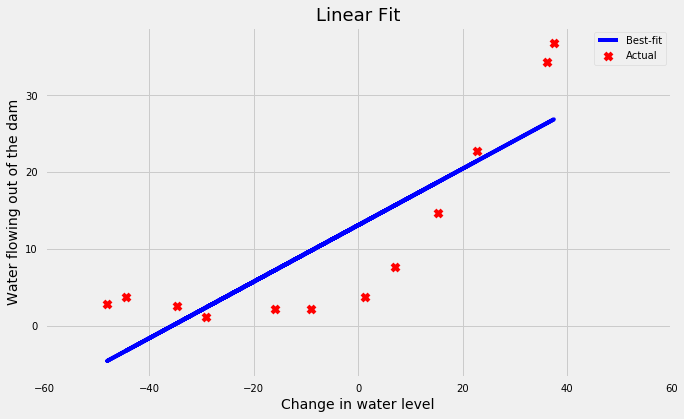

In [5]:
# Add ones to X before applying the learning algorithm
X = np.insert(X, 0, np.ones(mtrain), axis = 1)
theta_opt = trainLinearReg(X, y, 0)

# get training predictions to use in plotting the fitted line
pred = X.dot(theta_opt[:, np.newaxis])

# plot the scatter plot again and add the best-fit line
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(X[:, 1:], y, c = 'r', marker = 'x', label = 'Actual')
plt.plot(X[:, 1:], pred, 'b',label = 'Best-fit')
plt.xlim([-60, 60])
plt.legend(loc = 'upper right')
plt.xlabel('Change in water level', fontsize = 14)
plt.ylabel('Water flowing out of the dam', fontsize = 14)
plt.title('Linear Fit', fontsize = 18);

# print optimal theta
print('Optimal theta: [{:.4f}, {:.4f}]'.format(theta_opt[0], theta_opt[1]))

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Bias-variance
</h2><br>
One of the major concepts in machine learning is the *bias-variance tradeoff*. Models with high bias are not complex enough (too simple) for the data and tend to underfit. The simplest model is taking the average of target variable and assign it to all predictions. On the contrary, models with high variance overfit the training data by closely follow (mimick) the training data where the learning algorithms will follow the signal and the noise.

Derivation of **Bias-variance decomposition**:

$$MSE = E(y - \widehat{y})^2\\{}$$
$$= E(y - f + f - \widehat{y})^2\\{}$$
$$= E\big\{(y - f)^2 + 2(y - f)(f - \widehat{y}) + (f - \widehat{y})^2\big\};\quad substitute\ y = f + \epsilon\\{}$$
$$= E(\epsilon)^2 + E(f - \widehat{y})^2;\quad add\ and\ subtract\ E(\widehat{y})\\{}$$
$$= E(\epsilon)^2 + E(f - E(\widehat{y}) + E(\widehat{y}) - \widehat{y})^2\\{}$$
$$= E(\epsilon)^2 + E(f - E(\widehat{y}))^2 + E(\widehat{y} - E(\widehat{y}))^2\\{}$$
$$\Rightarrow MSE = var(\widehat{y}) + (Bias(\widehat{y}))^2 + var(\epsilon)\\{}$$

$var(\epsilon)$: Irreducible error that resulted from omitted features and unmeasured variation with each example.

$Bias(\widehat{y})$: Error that is introduced by approximating a real-life problem with a simple model.

$var(\widehat{y})$: amount by which $\widehat{y}$ would change if we estimated it using different data set.

Therefore, we can control only the variance and the bias of the $\widehat{y}$ **BUT NOT** irreducible error.

In [6]:
display(HTML("<table><tr><td><img src = '../images/BiasVariance.jpg'></td><td><img src = '../images/Interpretability.jpg'></td></tr></table>"))

,


As the graphs above show:
* the simpler the model the higher the bias.
* Anything to the right of minimum test error is considered overfitting.
* At first, bias decreases and variance increases **BUT** the test error decreases because the rate of decrease in bias is higher than that of variance. This continues until bias and variance intersects and the that would be the lowest error possible which is equal to the irreducible error. Any complexity after that would result in overfitting.
* As the complexity (flexibility) of the model increases $\rightarrow$ the model will become less interpretable such as Support Vector Machines (SVM).

Therefore, our job is to try to estimate the right level of complexity to try to achieve that minimum.

<h3 style="font-family: Georgia; font-size:1.8em;color:purple; font-style:bold">
Learning Curves
</h3><br>
Learning curves plot the training and cross validation errors as a function of training size. Since we only have 12 examples, we'll iterate over them where each time we add one example to the set until we include all examples. In real applications, we would have much bigger data so we would have bigger intervals. Remember to not include the hyperparameter when calculating the training and cross validation errors.

As the graph below shows, our model suffers from high bias because it's too simple to capture all the pattern in the data especially that there is a non-linearity in the data as the scatter plot showed us before. The cross validation error decreases very fast and levels off after 2 training examples and become very close to the training error. i.e $J_{train}(\theta) \approx J_{cv}(\theta)$

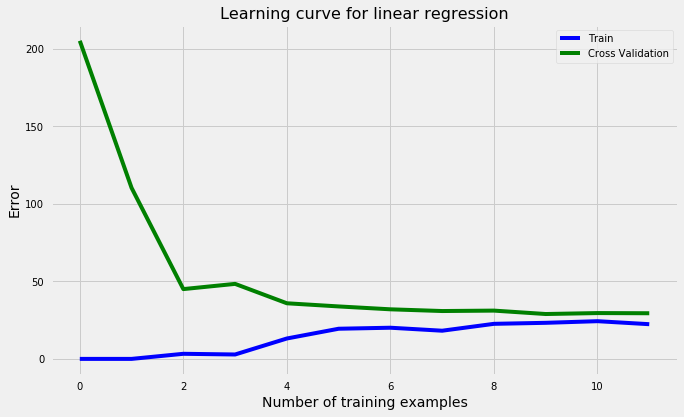

In [7]:
# compute the training and validation errors
Xval = np.insert(Xval, 0, np.ones(mval), axis = 1)
train_error, val_error = learningCurve(X, y, Xval, yval, 0)

# plot the learning curve
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(np.arange(mtrain), train_error, c = 'b', label = 'Train')
plt.plot(np.arange(mtrain), val_error, c = 'g', label = 'Cross Validation')
plt.legend(loc = 'upper right')
plt.xlabel('Number of training examples', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.title('Learning curve for linear regression', fontsize = 16);

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Polynomial Regression
</h2><br>
*"The truth is never linear!"* Linear models are relatively simple to describe and implement, and have advantages over other approaches in terms of interpretation and inference. However, standard linear regression can have significant limitations in terms of predictive power. This is because the linearity assumption is almost always an approximation, and sometimes a poor one. Let's use polynomial regression to address the non-linearity issue. The hypothesis function would look something like this:
$$h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_1^2 + \theta_3x_1^3 + .... + \theta_px_1^p$$

For this exercise we'll use polynomial of degree 8 just for illustration. However, we could've also used the degree in hyparameter tuning along with $\lambda$. Since the range will be very different for each feature, we should normalize it to have mean of zero and standard deviation of 1 so that the minimization algorithm doesn't take long to converge.

The first graph shows that the polynomial regressions fits the data really well since it's too complex. Moreover, polynomial regression is known to perform very poorly at the edges where the curve drops off. To test for bias/variance, we'll use the learning curve on the polynomial regression.

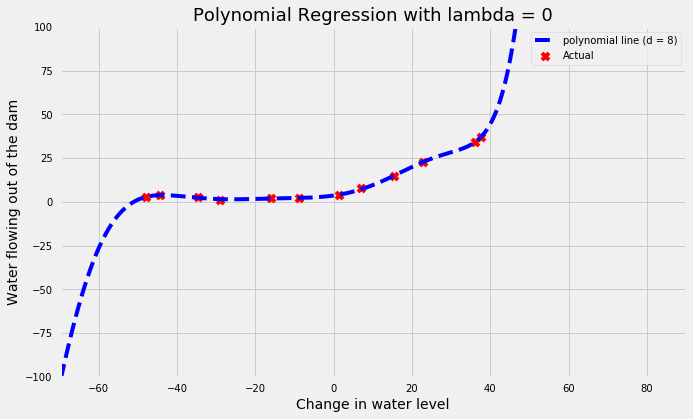

In [8]:
# computing 8th degree polynomial
poly = PolynomialFeatures(8, include_bias = False)
X_poly = poly.fit_transform(X[:, 1:])

# Don't use scale method in sklearn coz it uses population std not sample std
X_norm = (X_poly - X_poly.mean(axis = 0)) / X_poly.std(axis = 0, ddof = 1) # ddof = 1 means sample std
# add ones (bias)
X_norm = np.insert(X_norm, 0, np.ones(mtrain), axis = 1)

# fit polynomial regression with lambda = 0
theta_opt = trainLinearReg(X_norm, y, 0)

# plot the scatter plot again and add the best-fit polynomial line
x = np.linspace(X[:, 1].min() - 25, X[:, 1].max() + 10, 1000)[:, np.newaxis]
x_poly = poly.fit_transform(x)
x_norm = (x_poly - X_poly.mean(axis = 0)) / X_poly.std(axis = 0, ddof = 1)
# add ones (bias)
x_norm = np.insert(x_norm, 0, np.ones(x_norm.shape[0]), axis = 1)
pred = x_norm.dot(theta_opt[:, np.newaxis])

# plot
fig, ax = plt.subplots(figsize = (10, 6))
plt.scatter(X[:, 1:], y, c = 'r', marker = 'x', label = 'Actual')
plt.plot(x, pred, 'b--',label = 'polynomial line (d = 8)')
plt.xlim([-70, 90])
plt.ylim([-100, 100])
plt.legend(loc = 'upper right')
plt.xlabel('Change in water level', fontsize = 14)
plt.ylabel('Water flowing out of the dam', fontsize = 14)
plt.title('Polynomial Regression with lambda = 0', fontsize = 18);

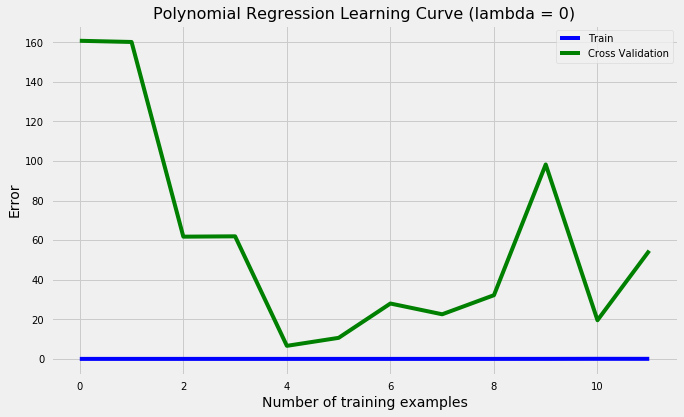

In [9]:
# transform to polynomial and normalize
Xval_poly = poly.fit_transform(Xval[:, 1:])
Xval_norm = (Xval_poly - X_poly.mean(axis = 0)) / X_poly.std(axis = 0, ddof = 1)
# add ones (bias)
Xval_norm = np.insert(Xval_norm, 0, np.ones(Xval_poly.shape[0]), axis = 1)

# compute the training and validation errors
train_error, val_error = learningCurve(X_norm, y, Xval_norm, yval, 0)

# plot the learning curve
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(np.arange(mtrain), train_error, c = 'b', label = 'Train')
plt.plot(np.arange(mtrain), val_error, c = 'g', label = 'Cross Validation')
plt.legend(loc = 'upper right')
plt.xlabel('Number of training examples', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.title('Polynomial Regression Learning Curve (lambda = 0)', fontsize = 16);

As the learning curve above shows, the cross validation error is high and the training error is close to zero which means our model suffers from overfitting which is expected. Also, the big gap between both errors is a good indication for overfitting. 

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Hyperparameter Tuning
</h2><br>
To solve high variance/overfitting issue, we'll increase the value of regularization parameter $\lambda$. We'll pick the appropriate level of complexity using validation curve that lets us pick the value of $\lambda$ that yields the lowest cross validation error.

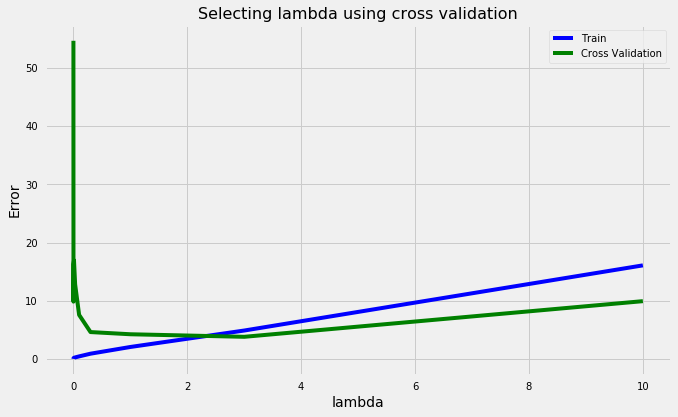

In [10]:
lambda_list = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_error, val_error = validationCurve(X_norm, y, Xval_norm, yval, lambda_list)

# plot the learning curve
fig, ax = plt.subplots(figsize = (10, 6))
plt.plot(lambda_list, train_error, c = 'b', label = 'Train')
plt.plot(lambda_list, val_error, c = 'g', label = 'Cross Validation')
plt.legend(loc = 'upper right')
plt.xlabel('lambda', fontsize = 14)
plt.ylabel('Error', fontsize = 14)
plt.title('Selecting lambda using cross validation', fontsize = 16);

The best value of **$\lambda$ is 3** which yields the lowest cross validation error. Also, we noticed that cross validation error is below training error due to randomnes of the splits of training/validation sets. Next, we'll fit the model using $\lambda = 3$ and apply it on the test set to get the test error.

In [11]:
# fit polynomial regression with the best lambda
theta_opt = trainLinearReg(X_norm, y, 3)

# transform to polynomial and normalize
Xtest_poly = poly.fit_transform(Xtest)
Xtest_norm = (Xtest_poly - X_poly.mean(axis = 0)) / X_poly.std(axis = 0, ddof = 1)
# add ones (bias)
Xtest_norm = np.insert(Xtest_norm, 0, np.ones(mtest), axis = 1)

# dont include lambda when calculating test error --> lambda = 0
cost = costReg(theta_opt, Xtest_norm, ytest, 0)
print('The test error using lambda = 3 is: {:.2f}'.format(cost))

The test error using lambda = 3 is: 3.86


<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
* Least squares standard linear regression is considered one of the simplest models in terms of interpretability and inference but almost always suffer from poor accuracy. That's because almost always the relationship between the target variable and the features are never linear.
* Learning curves help us in identifying bias/variance of our model when we have high dimensional data.
    * If the gap between cross validation error and training error is big $\rightarrow$ overfitting
    * If training error and cross validation error are very close $\rightarrow$ underfitting
* To solve underfitting problem, consider:
    * Adding more features
    * Adding non-linearity such as higher degree polynomial in case of linear regression
    * Decreasing $\lambda$
* To solve overfitting problem, consider:
    * Smaller set of features
    * Getting more training examples
    * Increasing $\lambda$
* Use validation curves for hyperparameter tuning to pick the value of the hyperparameter such as $\lambda$ that give the lowest cross validation error.
* When calculating cross validation and test errors, don't include any hyperparameter in the cost function.
* when normalizing features based on training data, use mean and standard deviation of the training data when normalizing validation and test sets.
* Mean Squared Error consists of Reducible and Irreducible erros. We can only control the reducible error which is $var(\widehat{y})$ and $(bias(\widehat{y}))^2$. The lowest error achievable equals the irreducible error $var(\epsilon)$. Also, the lowest test error is when $var(\widehat{y})$ = $(bias(\widehat{y}))^2$.